# Data Exploration

* The purpose of this notebook is to get insight into the data used in the experiments.
* We also explore the effect of using various preprocessing techniques on the CXR images from the dataset.
* Some of the generated figures are then saved and used in the written part of the thesis.

*Author: Dominik Chodounský, FIT CTU in Prague (Last edit: 05/11/21)*

## Library Imports

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.applications import Xception, VGG16, DenseNet121, VGG19, ResNet50
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import numpy as np
import umap
import random
import os
import sys


## File Imports
* Imports files containing helper functions and preprocessing functions.

In [2]:
from utils.utils import show_sample_grid
from preprocessing.image_preprocessing import *

## Gather Infromation About the Data

* Count the class occurances.

In [3]:
ROOT_PATH = '../'
TRAIN_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/train')
TEST_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/test')
CHEXNET = os.path.join(ROOT_PATH, 'data/CheXNet_weights.h5')

stats = {
        'train':
            {
            'negative': len(os.listdir(os.path.join(TRAIN_DIR, 'negative'))),
            'positive': len(os.listdir(os.path.join(TRAIN_DIR, 'positive')))
            }, 
        'test': 
            {'negative': len(os.listdir(os.path.join(TEST_DIR, 'negative'))),
             'positive': len(os.listdir(os.path.join(TEST_DIR, 'positive')))
             }
        }

* Set the plotting fonts to match the font used in the thesis.

In [4]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Compare the Class Distribution

* The training set is heavily imbalanced. This can have negative effect on the training process, the network may have a tendency to always predict the 'negative' class, because it will surely get most of the predictions correct. 
* Some class balancing or cost sensitive learning with class weights will have to be used.

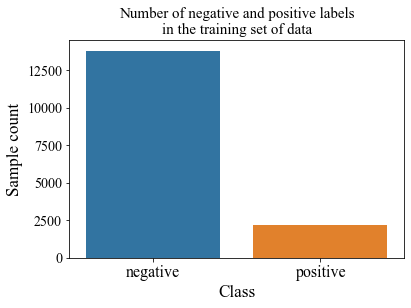

,number of samples
negative,13794
positive,2158


In [5]:
perc =  [float(i) for i in stats['train'].values()]
ax = sns.barplot(x=list(stats['train'].keys()), y=perc)
ax.set_title('Number of negative and positive labels\nin the training set of data', fontsize=15)
ax.set_ylabel('Sample count', fontsize=17)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xlabel('Class', fontsize=17)
ax.set_xticklabels(['negative', 'positive'], fontsize=16)

plt.show()
#plt.savefig(os.path.abspath(os.path.join(ROOT_PATH, 'diagrams/covidx8_train.pdf')), bbox_inches='tight', format='pdf')

display(pd.DataFrame.from_dict(stats['train'], orient='index', columns=['number of samples']))

* The test set was specifically made to be balanced, which ensures fair testing and gives us a more better insight into the performance of the model.

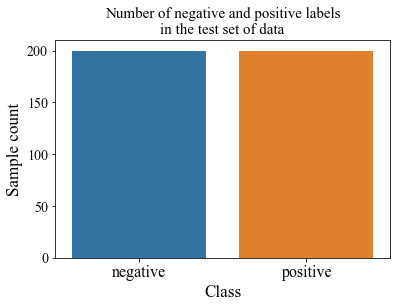

,number of samples
negative,200
positive,200


In [6]:
perc =  [float(i) for i in stats['test'].values()]
ax = sns.barplot(x=list(stats['test'].keys()), y=perc)
ax.set_title('Number of negative and positive labels\nin the test set of data', fontsize=15)
ax.set_ylabel('Sample count', fontsize=17)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xlabel('Class', fontsize=17)
ax.set_xticklabels(['negative', 'positive'], fontsize=16)

plt.show()
#plt.savefig(os.path.abspath(os.path.join(ROOT_PATH, 'diagrams/covidx8_test.pdf')), bbox_inches='tight', format='pdf')

display(pd.DataFrame.from_dict(stats['test'], orient='index', columns=['number of samples']))

## Display a Random Sample from the Images

* There don't seem to be any noticable differences between data in the training and the testing datasets. 
* We do see several abnormalities, where the X-ray scan captures some medical equipment (e.g. tubes, pacemakers,...) but those seem to be present in both datasets and they don't seem to be tied to a specific class label, therefore we can probably leave them in.

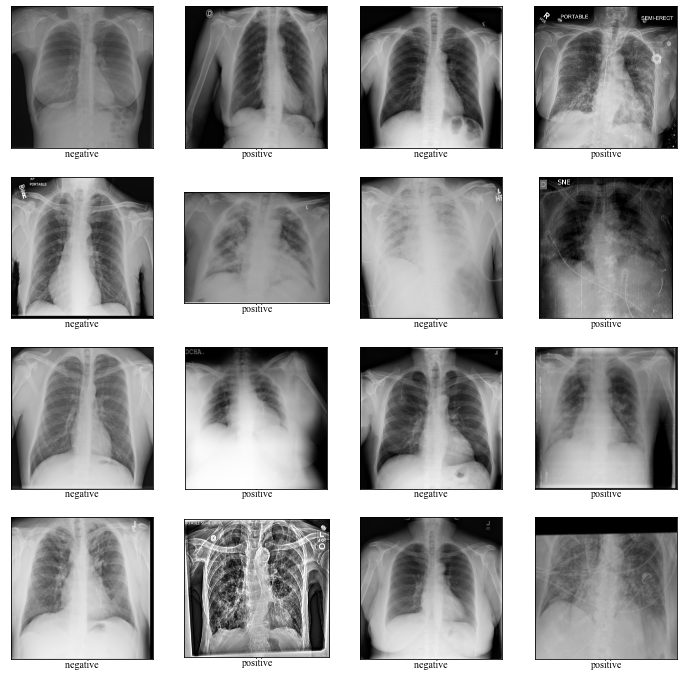

In [7]:
show_sample_grid(TRAIN_DIR, 4)

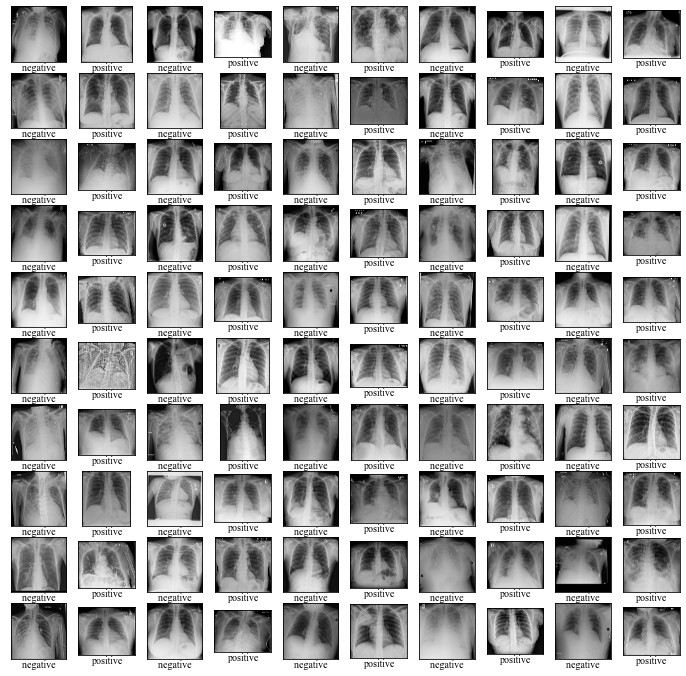

In [8]:
show_sample_grid(TEST_DIR, 10)

# Image preprocessing techniques

* Show examples of how our designed preprocessing functions work on the given data.

In [9]:
# selection of images to demonstrate the preprocessing techniques
imgs = [cv2.imread(os.path.join(ROOT_PATH, 'data/COVIDx8B/train/negative/DX.1.2.840.113564.1722810162.20200321204028829980.1203801020003.png')),
        cv2.imread(os.path.join(ROOT_PATH, 'data/COVIDx8B/train/negative/000003-5.jpg')),
        cv2.imread(os.path.join(ROOT_PATH, 'data/COVIDx8B/train/negative/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png')),
        cv2.imread(os.path.join(ROOT_PATH, 'data/COVIDx8B/train/negative/0609cacd-b9a6-485f-a6f1-5bb7b88db8dd.png')),
        cv2.imread(os.path.join(ROOT_PATH, 'data/COVIDx8B/train/positive/1-s2.0-S0085253820303616-gr1_lrg-a.png'))
        ]

## Diaphragm Removal with Polygon Approximation of the Contour

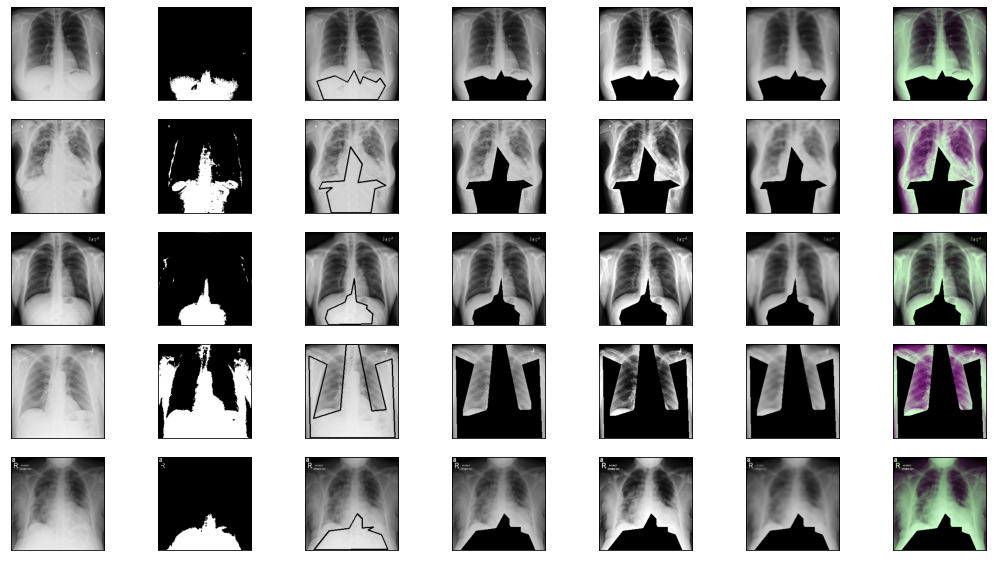

In [10]:
show_preprocessing(imgs=imgs, preprocessor=remove_diaphragm, figsize=(18, 10), mode='poly')

## Diaphragm Removal with Convex Hull Enclosure of the Contour

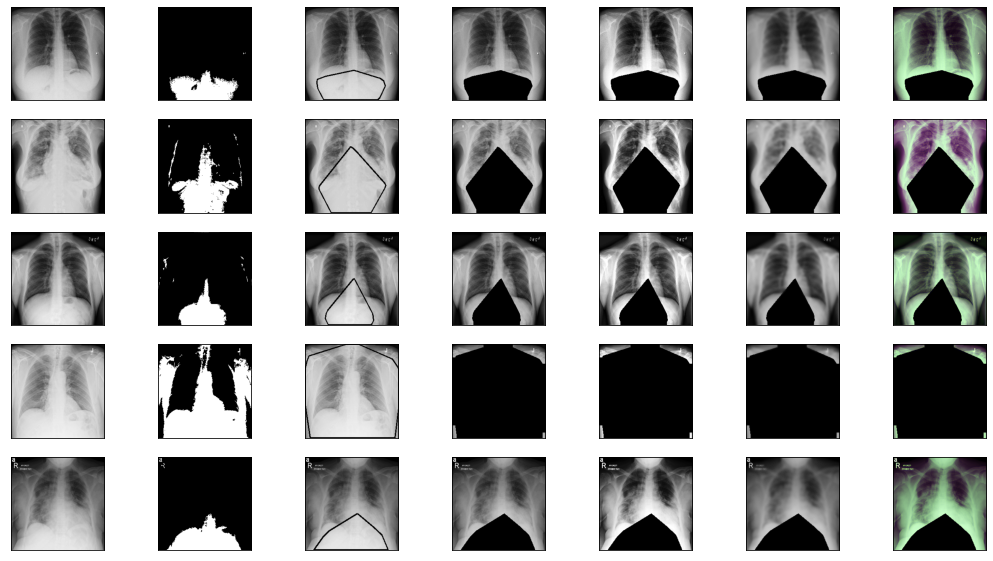

In [18]:
show_preprocessing(imgs=imgs, preprocessor=remove_diaphragm, figsize=(18, 10), mode='hull')

## Histogram Equalization

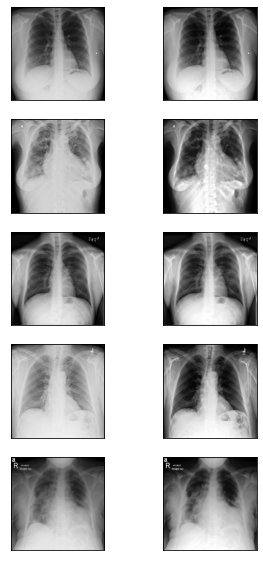

In [ ]:
show_preprocessing(imgs=imgs, preprocessor=rgb_histogram_equalization, figsize=(5, 10))

## Contrast Limited Adaptive Histogram Equalization (CLAHE)

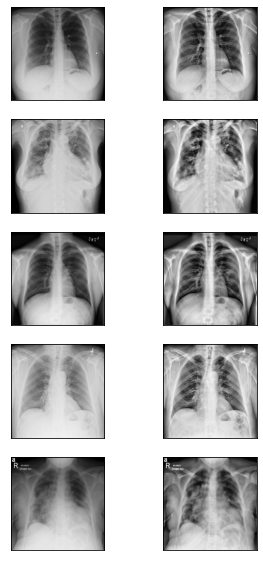

In [ ]:
show_preprocessing(imgs=imgs, preprocessor=rgb_clahe, figsize=(5, 10))

# *Create Diagrams of Preprocessing Techniques*

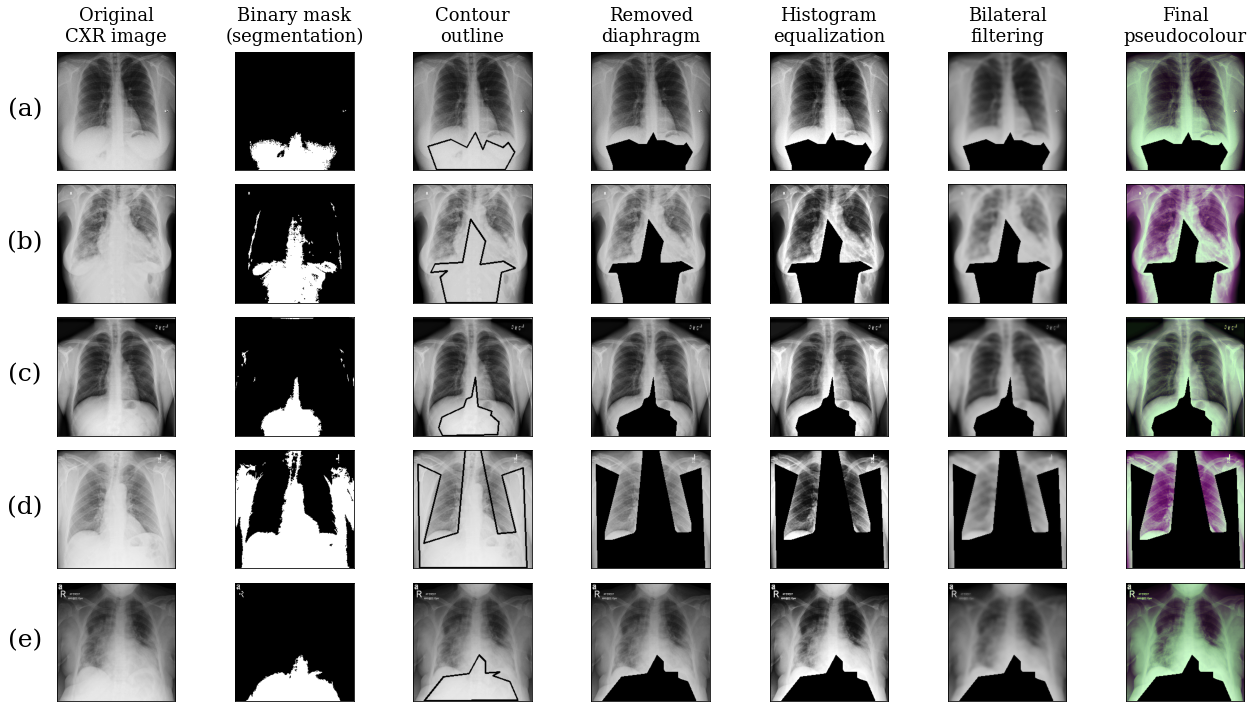

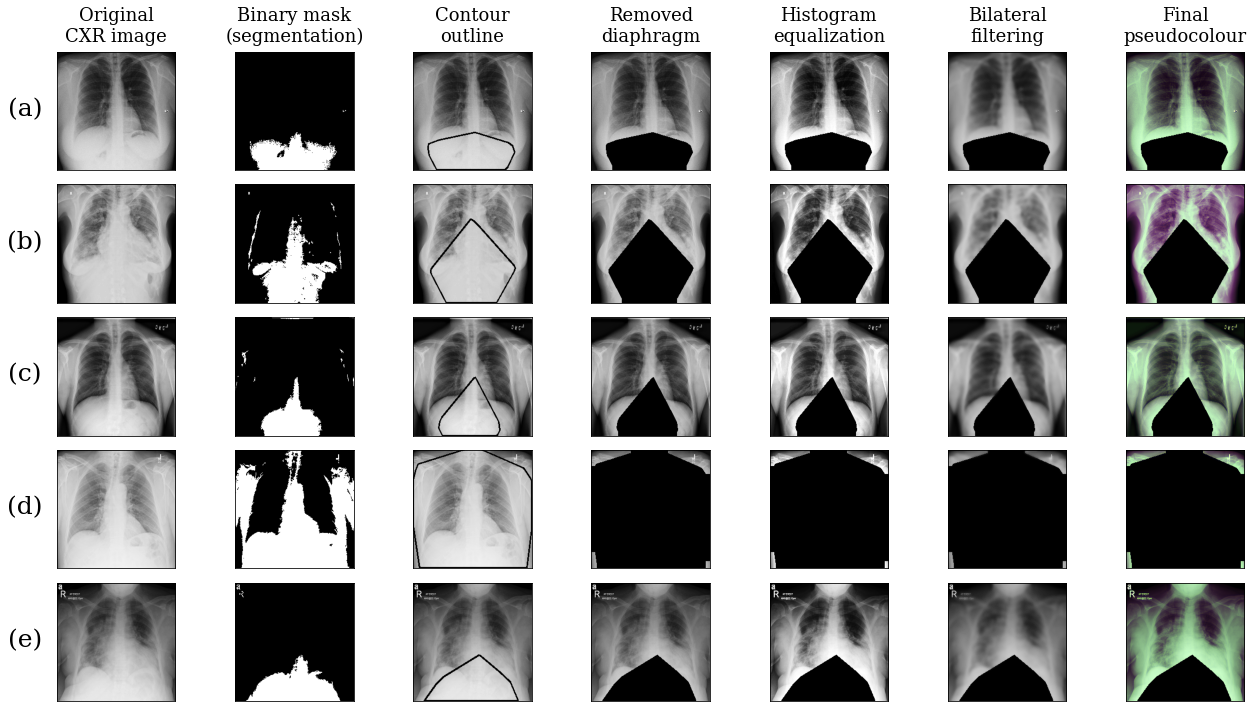

In [ ]:
rows = ['(a)       ', '(b)       ', '(c)       ', '(d)       ', '(e)       ']
cols = ['Original\nCXR image', 'Binary mask\n(segmentation)', 'Contour\noutline', 'Removed\ndiaphragm', 'Histogram\nequalization', 'Bilateral\nfiltering', 'Final\npseudocolour']

def save_preprocessing_diaphragm(imgs, preprocessor, figsize, mode=None):
    cnt = len(imgs)
    fig, axes = plt.subplots(nrows=cnt, ncols=7, figsize=figsize)

    for i in range(cnt):
        stages = list(preprocessor(imgs[i], mode=mode))
        columns = len(stages)
        for j in range(columns):
            axes[i, j].imshow(np.squeeze(stages[j]), vmin=0, vmax=255, cmap='gray')
            axes[i, j].get_xaxis().set_ticks([])
            axes[i, j].get_yaxis().set_ticks([])

    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=18, pad=10)
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size=25, position=(0, 0.42))

    fig.tight_layout()
    plt.show()
    #plt.savefig(os.path.abspath(os.path.join(ROOT_PATH, 'diagrams/rm_diaphragm_' + str(mode) + '.pdf')), bbox_inches='tight', format='pdf')

save_preprocessing_diaphragm(imgs=imgs, preprocessor=remove_diaphragm, figsize=(18, 10), mode='poly')
save_preprocessing_diaphragm(imgs=imgs, preprocessor=remove_diaphragm, figsize=(18, 10), mode='hull')

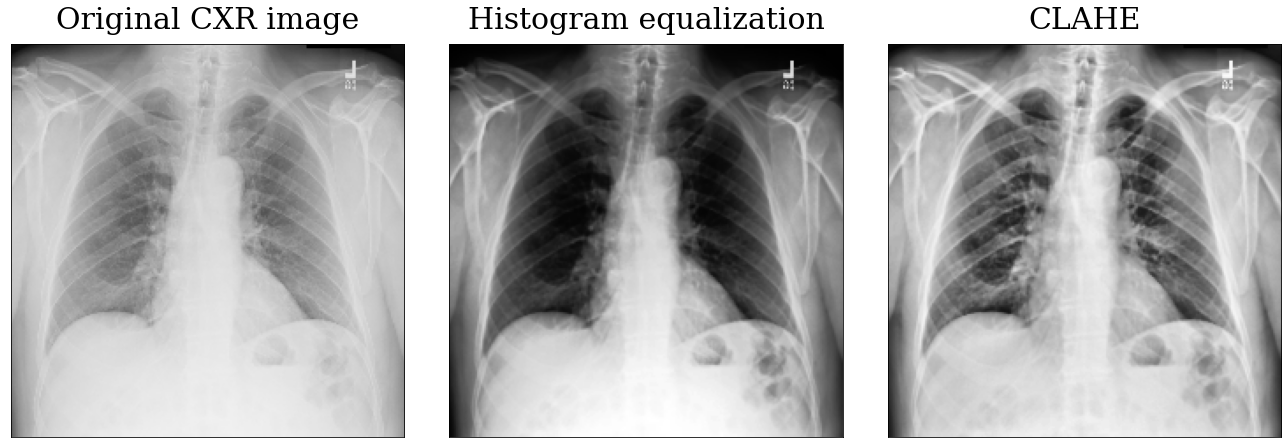

In [ ]:
cols = ['Original CXR image', 'Histogram equalization', 'CLAHE']

def save_preprocessing_histogram(img, preprocessor, figsize, mode=None):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    arr = np.array(rgb_histogram_equalization(img))
    stages = np.array([arr[0], arr[1], np.array(rgb_clahe(img)[-1])])
    for j in range(len(stages)):
        axes[j].imshow(np.squeeze(stages[j]), vmin=0, vmax=255, cmap='gray')
        axes[j].get_xaxis().set_ticks([])
        axes[j].get_yaxis().set_ticks([])

    for ax, col in zip(axes, cols):
        ax.set_title(col, fontsize=30, pad=15)

    fig.tight_layout()
    plt.show()
    #plt.savefig(os.path.abspath(os.path.join(ROOT_PATH, 'diagrams/preprocess_histogram.pdf')), bbox_inches='tight', format='pdf')

save_preprocessing_histogram(img=imgs[3], preprocessor=rgb_histogram_equalization, figsize=(18, 10), mode='poly')

# Demonstration of Filtering Methods

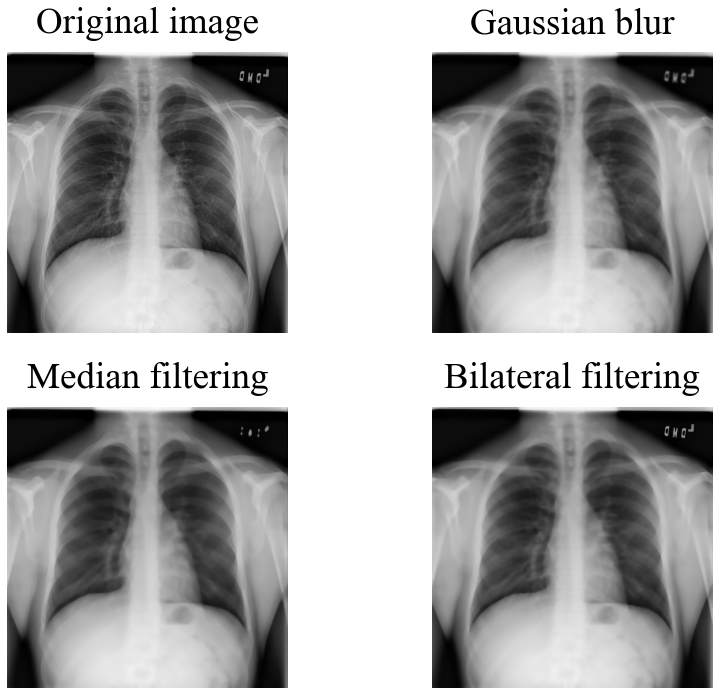

In [19]:
original = cv2.imread(os.path.join(ROOT_PATH, 'data/COVIDx8B/train/negative/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png'))

filter_size = 17
gaussian = cv2.GaussianBlur(original,(filter_size, filter_size),0)
median = cv2.medianBlur(original, filter_size)
bilateral = cv2.bilateralFilter(original, filter_size, 75, 75)

fig, axs = plt.subplots(2, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=-0.7)

size = 37
pad = 20

axs[0, 0].imshow(original)
axs[0, 0].set_title('Original image', fontsize=size, pad=pad)
axs[0, 1].imshow(gaussian)
axs[0, 1].set_title('Gaussian blur', fontsize=size, pad=pad)
axs[1, 0].imshow(median)
axs[1, 0].set_title('Median filtering', fontsize=size, pad=pad)
axs[1, 1].imshow(bilateral)
axs[1, 1].set_title('Bilateral filtering', fontsize=size, pad=pad)

plt.tight_layout()
[axi.set_axis_off() for axi in axs.ravel()]

plt.show()
#plt.savefig(os.path.abspath(os.path.join(ROOT_PATH, 'diagrams/denoising.jpg')), bbox_inches='tight', format='jpg')

## Uniform Manifold Approximation and Projection (UMAP) for Dimensionality Reduction

* Use a pre-trained CNN to extract features from the data and then reduce the features' dimensionality with UMAP to explore whether the classes are visually separable in 2D and 3D space.

In [5]:
RAND_SEED = 113
random.seed(RAND_SEED)

# select a random sample of 500 images from the positive class and 500 from the negative class
pos = random.sample(list(os.listdir(os.path.join(TRAIN_DIR,'positive'))), 500)
neg = random.sample(list(os.listdir(os.path.join(TRAIN_DIR, 'negative'))), 500)

# load selected images
pos = [cv2.imread(os.path.join(os.path.join(TRAIN_DIR,'positive', x))) for x in pos]
neg = [cv2.imread(os.path.join(os.path.join(TRAIN_DIR,'negative', x))) for x in neg]

* Build feature extractor.

In [6]:
'''
Using other feature extractors pre-trained on ImageNet

convolutional_base = Xception(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))
feature_map = keras.layers.Flatten()(convolutional_base.layers[-1].output)
extractor = Model(inputs=[convolutional_base.inputs], outputs=[feature_map])
extractor.compile(
            optimizer=keras.optimizers.Adam(0.0001),
            metrics=keras.metrics.BinaryAccuracy(), 
            loss=keras.losses.BinaryCrossentropy() 
        )
'''

# CheXNet feature extractor pre-trained on ChestX-ray14 data 
convolutional_base = DenseNet121(include_top=False, weights=None, pooling='max', input_shape=(224, 224, 3))
original_output = keras.layers.Dense(14, activation='sigmoid', name='output')(convolutional_base.layers[-1].output)
chexnet = keras.Model(inputs=[convolutional_base.input], outputs=[original_output])
chexnet.load_weights(CHEXNET)

extractor = Model(inputs=[convolutional_base.inputs], outputs=[chexnet.layers[-2].output])
extractor.compile(
            optimizer=keras.optimizers.Adam(0.0001),
            metrics=keras.metrics.BinaryAccuracy(), 
            loss=keras.losses.BinaryCrossentropy() 
        )

* Extract features for all selected samples.

In [ ]:
def umap_preprocessor(img):
    new_img = cv2.resize(img.astype('uint8'), (224, 224))
    new_img = np.expand_dims(new_img, axis=0)
    return new_img

pos2 = [extractor.predict(umap_preprocessor(x)) for x in pos]
neg2 = [extractor.predict(umap_preprocessor(x)) for x in neg]
data = np.concatenate([pos2, neg2]).squeeze()

pos_labels = [1 for i in pos]
neg_labels = [0 for i in neg]
labels = np.concatenate([pos_labels, neg_labels])

* Reduce the feature dimensionality to 2D and 3D.

In [ ]:
reducer3d = umap.UMAP(random_state=RAND_SEED, n_components=3, n_neighbors=50, min_dist=0.4, metric='euclidean')
reducer3d.fit(data)
reducer2d = umap.UMAP(random_state=RAND_SEED, n_components=2, n_neighbors=50, min_dist=0.4, metric='euclidean')
reducer2d.fit(data)

embedding3d = reducer3d.transform(data)
embedding2d = reducer2d.transform(data)

* Plot the transforemd features.

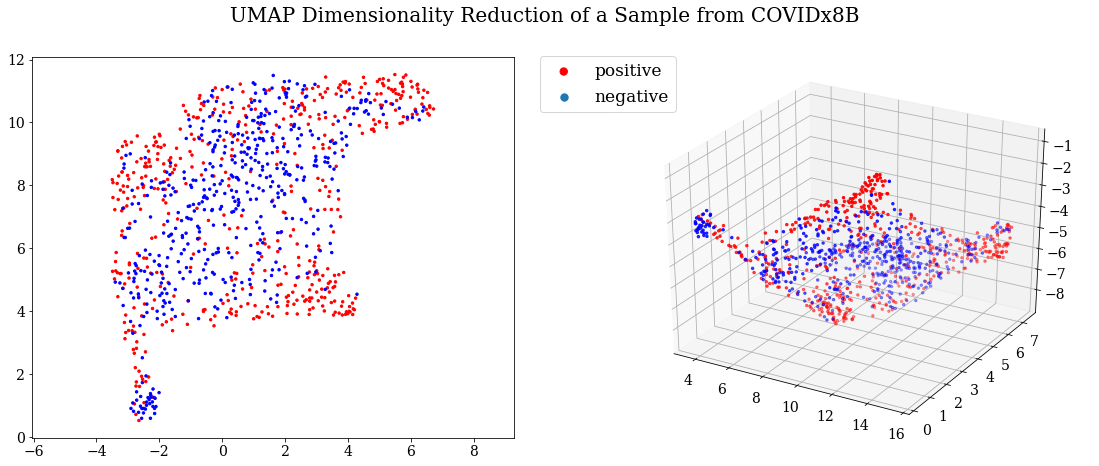

In [ ]:
fig = plt.figure(figsize=(19,7))

ax1 = fig.add_subplot(122, projection='3d')
im = ax1.scatter(embedding3d[:, 0], embedding3d[:, 1], embedding3d[:, 2], c=labels, cmap=plt.get_cmap('bwr', 2), s=6)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = fig.add_subplot(121)
ax2.scatter(embedding2d[:, 0], embedding2d[:, 1], c=labels, cmap=plt.get_cmap('bwr', 2), s=6)
ax2.tick_params(axis='both', which='major', labelsize=14)

fig.gca().set_aspect('equal', 'datalim')
#fig.colorbar(im, ax=[ax1,ax2])
fig.legend(['positive', 'negative'], fontsize=17, markerscale=3, bbox_to_anchor=(-0, 0.33, 0.5, 0.5))

fig.suptitle('UMAP Dimensionality Reduction of a Sample from COVIDx8B', fontsize=20)

plt.show()
#plt.savefig(os.path.abspath(os.path.join(ROOT_PATH, 'diagrams/umap.pdf')), bbox_inches='tight', format='pdf')